In [1]:
import numpy as np
import matplotlib.pyplot as plt
from z3 import *
import torch
import time
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from Z3_Tools import *

## (1) Z3 Logic 

In [2]:
s = Solver()
s.add(parse("A|B"))
s.add(parse("A->C"))
s.add(parse("B->C"))
s.add(Not(parse("C")))

print(s.check())

unsat


In [3]:
## Test Verifier 
known = ["A|B", "A->C"]
proposal = "C"

is_valid = verify_step(known, proposal)
print("Is the step valid?", is_valid)

Is the step valid? False


## (2) Enumerate Propositional Logic Statements

In [199]:
ALL_FORMULAS = ["A", "B", "C", "D",
                "~A", "~B", "~C",  "~D", 
                "A->B", "A->C", "B->C", "A->D", "B->D", "C->D",
                "B->A", "C->A", "C->B", "D->A", "D->B", "D->C",
                "A&B", "B&C", "A&C", "A&D", "B&D", "C&D", 
                "A|B", "B|C", "A|C", "A|D", "B|D", "C|D", ]

# Define ALL_STATES from many random subsets of ALL_FORMULAS
# Ignore false states (check this by ensuring a -> false is false, which means a is true) 
N = 6000; ALL_STATES = set(); 
while len(ALL_STATES) < N: 
    subset = frozenset(random_subset(ALL_FORMULAS, 1, 4))
    if not verify_step(list(subset), "A & ~A"): 
        ALL_STATES.add(subset)
print(len(ALL_STATES))

6000


In [200]:
total = len(ALL_STATES) * len(ALL_FORMULAS)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known = list(known)
    for prop in ALL_FORMULAS:
        label = verify_step(known, prop)
        
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(int(label))
        count += 1
        if count % 50000 == 0:
            print(f"{count} / {total} samples done")

50000 / 192000 samples done
100000 / 192000 samples done
150000 / 192000 samples done


In [201]:
print(X_states[5])
print(X_props[5])
print(Y_labels[5])

['A&D', 'C->A', 'C&D', '~B']
~B
1


In [202]:
## Can also save to .npz and load later ... 
# data = np.load("logic_dataset.npz")
# X_states = data["X_states"]
# X_props  = data["X_props"]
# Y        = data["Y"]

## (3) Train on Prop Logic 

In [203]:
# Define one-hot-encoding map and state encoder 
OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}

# Map X_props, X_states to One-Hot 
X_props_Map = np.array([OneHot_Map[p] for p in X_props])
X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_Map]  # basically defining a repeating list of I rows ... 
X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])

print(X_props[8])
print(X_props_Map[15])
print(X_props_1h[15])
print(X_states[15])
print(X_states_1h[5])

A->B
15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
['A&D', 'C->A', 'C&D', '~B']
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0.]


0 0.6905913949012756
50 0.5172829627990723
100 0.33754757046699524
150 0.1475042849779129
200 0.0719200149178505
250 0.039251089096069336


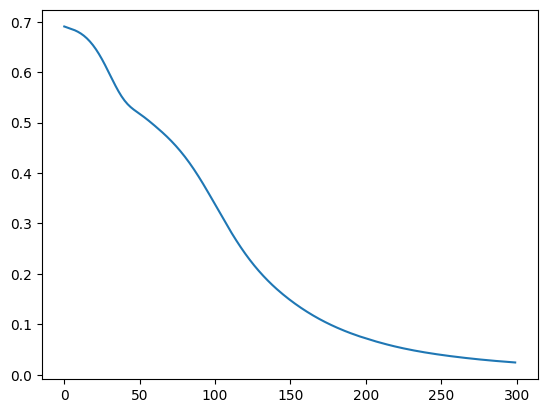

In [204]:
## Define X, Y, train/test split 
X = np.concatenate([X_props_1h, X_states_1h], axis=1)
Y = np.array(Y_labels).astype(float)
Xtr, Xte, ytr, yte = train_test_split(X, Y, test_size=0.2, random_state=0)

## Define model 
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

## Train
Xt = torch.tensor(Xtr, dtype=torch.float32)
yt = torch.tensor(ytr, dtype=torch.float32).unsqueeze(1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
for epoch in range(300):
    opt.zero_grad()
    ypred = model(Xt)
    loss = loss_fn(ypred, yt)
    loss.backward()
    opt.step()
    if epoch%50==0: print(epoch, loss.item())
    losses.append(loss.item())

plt.plot(losses);

In [206]:
# Eval 
with torch.no_grad():
    Xtest = torch.tensor(Xte, dtype=torch.float32)
    ytest = torch.tensor(yte, dtype=torch.float32).unsqueeze(1)
    preds = (model(Xtest) > 0.5).float()
    acc = (preds == ytest).float().mean()

print("Test accuracy:", acc.item())

Test accuracy: 0.9930208325386047


# (4) Baby Theorem Prover

In [207]:
testinput = np.concatenate([encode_state(['A', 'C'], ALL_FORMULAS), encode_state(['B'], ALL_FORMULAS)])
torch_input = torch.tensor([testinput], dtype=torch.float32)
test_output = model(torch_input)
print(test_output.item())

0.002471528248861432


In [208]:
## Idea: 
## (1) NN is given a state, gives probability of truth for a given formula.
## (2) Each formula is ranked based on the model. 
## (3) Highest rank is 'chosen' (if it agrees with Z3)

example_state = ['A', 'C']
print(nn_score(example_state, 'B', model, ALL_FORMULAS))
print(rank_candidates(example_state, model, ALL_FORMULAS))
print(pick_valid_step(example_state, model, ALL_FORMULAS, 5))

0.002471528248861432
[('A&C', 0.9999996423721313), ('A', 0.9866740703582764), ('C', 0.9796134233474731), ('C&D', 0.9753628373146057), ('B&C', 0.9739128947257996), ('A&D', 0.9445962309837341), ('A&B', 0.9250934720039368), ('A|C', 0.27245083451271057), ('D->A', 0.09533126652240753), ('B->C', 0.049518853425979614), ('B|C', 0.035035181790590286), ('A|B', 0.0259816013276577), ('B->A', 0.019861383363604546), ('D->C', 0.012327250093221664), ('~D', 0.01172591932117939), ('~B', 0.009761187247931957), ('C|D', 0.007836675271391869), ('A|D', 0.003976817242801189), ('A->C', 0.0037299480754882097), ('C->A', 0.0034097214229404926), ('B', 0.002471528248861432), ('B&D', 0.0017001567175611854), ('B|D', 0.0011026662541553378), ('D', 0.0010739624267444015), ('D->B', 0.0007911178981885314), ('C->B', 0.00035739204031415284), ('A->D', 0.0002802264643833041), ('A->B', 0.0002474083157721907), ('B->D', 0.00017356812895741314), ('C->D', 0.00011441953392932191), ('~A', 2.6777912353281863e-05), ('~C', 8.4833409346

In [209]:
rank_candidates(['A', 'A->B', 'B->C'], model, ALL_FORMULAS)

[('B&C', 0.9999998807907104),
 ('A&C', 0.9999998807907104),
 ('A&B', 0.9999994039535522),
 ('B->C', 0.9999929666519165),
 ('C', 0.9999922513961792),
 ('A->B', 0.9999809265136719),
 ('A', 0.9999587535858154),
 ('~B', 0.9999330043792725),
 ('B', 0.9999147653579712),
 ('C&D', 0.9998748302459717),
 ('B->A', 0.9997913241386414),
 ('~A', 0.9997351765632629),
 ('B&D', 0.9994693398475647),
 ('A->C', 0.9994446635246277),
 ('A|C', 0.9992733597755432),
 ('C->B', 0.9988362193107605),
 ('A|D', 0.9984326958656311),
 ('A|B', 0.9982975125312805),
 ('B|C', 0.9977511763572693),
 ('D->A', 0.9971985816955566),
 ('~D', 0.9969618916511536),
 ('C|D', 0.9960078001022339),
 ('B|D', 0.9957849383354187),
 ('D->C', 0.9954258799552917),
 ('D->B', 0.9940967559814453),
 ('C->A', 0.99379563331604),
 ('A&D', 0.9916580319404602),
 ('A->D', 0.9735836386680603),
 ('B->D', 0.9508017301559448),
 ('D', 0.9504513144493103),
 ('~C', 0.9419160485267639),
 ('C->D', 0.8196074962615967)]

In [210]:
def TheoremProver(state, objective, model, ALL_FORMULAS): 
    while objective not in state: 
        winner = pick_valid_step(state, model, ALL_FORMULAS, 10)[0]
        if winner is None: 
            print("No valid step found. Proof failed.")
            return None
        print(f'NN guess : {winner}')
        state.append(winner)
        print(f'New state: {state}')
    print('Proved!')

In [211]:
TheoremProver(['A', 'A->B', 'B->C'], 'C', model, ALL_FORMULAS)
TheoremProver(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS)


NN guess : B&C
New state: ['A', 'A->B', 'B->C', 'B&C']
NN guess : A&C
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C']
NN guess : C
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C', 'C']
Proved!
NN guess : A&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&D']
NN guess : C&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&D', 'C&D']
NN guess : D
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&D', 'C&D', 'D']
Proved!


In [212]:
## Very inefficient theorem prover... it's blind to the goal! 

## In our list of random subsets, A->B *always* comes with A, and not necessarily B. 
## So P(B | A, A->B) is small, and P(B | A, A&B) is larger. Therefore when the NN sees 
## A and A->B, it doesn't automatically guess "B". 

## (5) Goal-Conditioned Theorem Prover

In [213]:
## Make sure verify_step_small can parse all tiny steps ... 
print(verify_step_small(['A', 'A->B', 'B->C'], 'B'))
print(verify_step_small(['A', 'A->B', 'B->C'], 'C'))
print(verify_step_small(['A&B'], 'A'))
print(verify_step_small(['A', 'B'], 'A&B'))
print(verify_step_small(['A'], 'A|B'))
print(verify_step_small(['A|B', '~B'], 'A'))

# Can enforce other rules of logic later ... 
print(verify_step_small(['A->B', '~B'], '~A'))
print(verify_step_small(['A|B', 'A->C', 'B->C'], 'C'))

True
False
True
True
True
True
False
False


In [214]:
## Use small steps to find *true* shortest paths for proofs
print(find_shortest_proof(['A', 'A->B', 'B->C'], 'C', ALL_FORMULAS, 5))
print(find_shortest_proof(['A', 'A->B', 'B->C', 'C->A'], 'A&B', ALL_FORMULAS, 5))

['B', 'C']
['B', 'A&B']


In [329]:
## Generate new & improved data (includes steps)

## First just make a new [X_states, X_props] array ... don't have trivial examples. 
total = len(ALL_STATES) * len(ALL_FORMULAS)
print(total)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known_list = list(known)
    all_paths = find_all_shortest_proofs(known_list, ALL_FORMULAS, 5)
    
    for prop in ALL_FORMULAS:
        
        count += 1
        if count % 20000 == 0:
            print(f"{count} / {total} samples done")
            
        # skip if trivial or unreachable
        if prop in known_list: continue
        if prop not in all_paths: continue
        
        path = all_paths[prop]
            
        # append ... 
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(path[0])

            
print(len(X_states), len(X_props))

192000
20000 / 192000 samples done
40000 / 192000 samples done
60000 / 192000 samples done
80000 / 192000 samples done
100000 / 192000 samples done
120000 / 192000 samples done
140000 / 192000 samples done
160000 / 192000 samples done
180000 / 192000 samples done
32997 32997


In [300]:
## Example of training data  ... 
print(X_states[3])
print(X_props[3])
print(Y_labels[3])

frozenset({'A&D', 'C->A', 'C&D', '~B'})
A&C
A


In [301]:
## One-hot encoding 
OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}

X_props_num = np.array([OneHot_Map[p] for p in X_props])
X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_num] # basically defining a repeating list of I rows ... 
X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])
Y_labels_num = np.array([OneHot_Map[p] for p in Y_labels])
Y_labels_1h = np.eye(len(ALL_FORMULAS))[Y_labels_num]

print(OneHot_Map)
print(X_props_num[3])
print(X_props_1h[3])
print(X_states_1h[3])
print(Y_labels_num[3])
print(Y_labels_1h[3])

{'A': 0, 'B': 1, 'C': 2, 'D': 3, '~A': 4, '~B': 5, '~C': 6, '~D': 7, 'A->B': 8, 'A->C': 9, 'B->C': 10, 'A->D': 11, 'B->D': 12, 'C->D': 13, 'B->A': 14, 'C->A': 15, 'C->B': 16, 'D->A': 17, 'D->B': 18, 'D->C': 19, 'A&B': 20, 'B&C': 21, 'A&C': 22, 'A&D': 23, 'B&D': 24, 'C&D': 25, 'A|B': 26, 'B|C': 27, 'A|C': 28, 'A|D': 29, 'B|D': 30, 'C|D': 31}
22
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0.]
0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


0 3.480433225631714
200 0.38453546166419983
400 0.16166242957115173
600 0.04549305513501167
800 0.01648503728210926
1000 0.007052726577967405
1200 0.0036509521305561066
1400 0.0021855963859707117


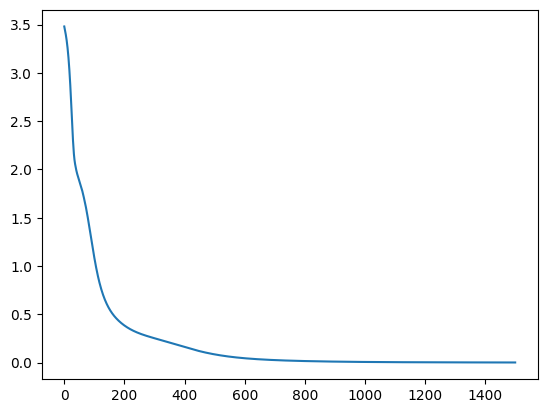

In [302]:
##########################
## Train NN on new data ##
##########################

## Define X, Y, train/test split 
X = np.concatenate([X_states_1h, X_props_1h], axis=1)
Y = Y_labels_num
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=0)

## Define model 
model = nn.Sequential(
                nn.Linear(X.shape[1], 128), 
                nn.ReLU(), 
                nn.Linear(128, 64), 
                nn.ReLU(), 
                nn.Linear(64, len(ALL_FORMULAS)),
)

## Train
Xt = torch.tensor(Xtr, dtype=torch.float32)
yt = torch.tensor(Ytr, dtype=torch.long)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

losses = []
for epoch in range(1500):
    opt.zero_grad()
    loss = loss_fn(model(Xt), yt)
    loss.backward()
    opt.step()
    if epoch%200==0: print(epoch, loss.item())
    losses.append(loss.item())

plt.plot(losses);

In [307]:
print(Xte[1])
print(Yte[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0


In [308]:
n_formulas = len(ALL_FORMULAS)

x = Xte[2]

state_bits = x[:n_formulas]
goal_bits  = x[n_formulas:]

state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]

print("state:", state_formulas)
print("goal:", goal_formula)
print("label:", Yte[2])


state: ['C->D', 'A&B', 'B&C', 'B|C']
goal: D
label: 2


In [309]:
def test_example(num):
    state_bits = Xte[num][:len(ALL_FORMULAS)]
    goal_bits  = Xte[num][len(ALL_FORMULAS):]
    state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
    goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]
#     print("state:", state_formulas)
#     print("goal:", goal_formula)
#     print("label:", Yte[2])
    return {'state': state_formulas, 'goal': goal_formula}

## (6) Improved Theorem Prover

In [310]:
# Not even sure if this is in train or test set .... 
state_check = encode_state(['A', 'A->B', 'B->C'], ALL_FORMULAS)
goal_check =  encode_state(['C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[-10.7234,  15.9514,   8.4168,   3.8601,  -9.4218,  -9.2977, -11.6322,
          -9.6375, -12.7594, -11.6248,  -8.9111, -11.8951, -10.1404, -10.7200,
          -9.8412, -11.5335, -11.7389, -11.5717, -12.8650,  -9.1274,   2.9854,
           1.5329,   1.9437,   0.7143,  -2.7851,  -6.6833,   2.2126,  -3.0379,
           6.1018,  -4.8224, -11.2327,  -7.1739]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [311]:
state_check = encode_state(['A->B', 'A->C', 'D->C', 'B&D'], ALL_FORMULAS)
goal_check =  encode_state(['B|C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[  5.7027,  26.0932,   7.8196,  12.9864, -13.0361, -14.3103, -14.4961,
         -12.9250, -16.3024, -16.0046, -12.8172, -14.1510, -12.3452, -13.4990,
         -12.1170, -12.7224, -14.4109, -13.5834, -16.9048, -13.1160,  -6.4548,
           4.9616,  -7.3098, -15.0300,  -1.6607,  -3.1914,  -9.4715,  13.4439,
          -4.6636, -23.9897,  -2.7508,  -3.3102]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [312]:
# def TheoremProver2(state, objective, model, ALL_FORMULAS): 
#     counter = 0
# #     print(f'given  :  {state}')
# #     print(f'goal is: {objective}')
#     while objective not in state: 
#         counter+=1
#         x = np.concatenate([encode_state(state, ALL_FORMULAS), encode_state([objective], ALL_FORMULAS)])
#         tt = torch.tensor([x], dtype=torch.float32)
#         logits = model(tt) 
#         bestguess = ALL_FORMULAS[torch.argmax(logits).item()]
#         if bestguess in state: break
#         state.append(bestguess)
#         print(f'New state: {state}')
#         if counter>5: break
#     print('Proved!')


def TheoremProver2(state, objective, model, ALL_FORMULAS): 
    counter = 0
    nF = len(ALL_FORMULAS)

    while objective not in state: 
        counter += 1
        
        # Encode
        x = np.concatenate([encode_state(state, ALL_FORMULAS), encode_state([objective], ALL_FORMULAS)])
        tt = torch.tensor([x], dtype=torch.float32)
        logits = model(tt)[0]
        ranked = torch.argsort(logits, descending=True)

        # Try top-k predictions (k = 5 is fine)
        chosen = None
        for idx in ranked[:10]:
            guess = ALL_FORMULAS[idx.item()]
            if guess not in state:
                chosen = guess
                break

        # If none available → stuck
        if chosen is None:
            print("Stuck: all top-k guesses were already in state.")
            break

        # Use the chosen formula
        state.append(chosen)
        print("New state:", state)

        if counter > 10:
            print("Giving up after 10 steps.")
            break

    print("Proved!")


In [313]:
# 2 step exapmles 
TheoremProver2(['A', 'A->B', 'B->C'], 'C', model, ALL_FORMULAS)
TheoremProver2(['A|B', '~A', 'B->C'], 'C', model, ALL_FORMULAS)
TheoremProver2(['C', 'C->B', 'A'], 'A&B', model, ALL_FORMULAS)
TheoremProver2(['A->B', 'A->C', 'D->C', 'B&D'], 'B|C', model, ALL_FORMULAS)
# 3 step examples 
TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS)
TheoremProver2(['A|B', '~B', 'A->C', 'C->D'], 'D', model, ALL_FORMULAS)
# 4 step examples
# TheoremProver2(['A', 'B', '(A&B)->C', 'C->D'], 'D', model, ALL_FORMULAS)

New state: ['A', 'A->B', 'B->C', 'B']
New state: ['A', 'A->B', 'B->C', 'B', 'C']
Proved!
New state: ['A|B', '~A', 'B->C', 'B']
New state: ['A|B', '~A', 'B->C', 'B', 'C']
Proved!
New state: ['C', 'C->B', 'A', 'B']
New state: ['C', 'C->B', 'A', 'B', 'A&B']
Proved!
New state: ['A->B', 'A->C', 'D->C', 'B&D', 'B']
New state: ['A->B', 'A->C', 'D->C', 'B&D', 'B', 'B|C']
Proved!
New state: ['A', 'A->B', 'B->C', 'C->D', 'B']
New state: ['A', 'A->B', 'B->C', 'C->D', 'B', 'C']
New state: ['A', 'A->B', 'B->C', 'C->D', 'B', 'C', 'D']
Proved!
New state: ['A|B', '~B', 'A->C', 'C->D', 'A']
New state: ['A|B', '~B', 'A->C', 'C->D', 'A', 'C']
New state: ['A|B', '~B', 'A->C', 'C->D', 'A', 'C', 'D']
Proved!


## (7) Faster than Z3 ?  

In [330]:
def TimeToProve(state, goal):
    ns_times = []
    bfs_times = []
    for _ in range(100):
        # Neuro-Symbolic
        t0ns = time.time()
        TheoremProver2(state.copy(), goal, model, ALL_FORMULAS)
        t1ns = time.time()
        ns_times.append((t1ns - t0ns) * 1000)

        
        # BFS
        t0bfs = time.time()
        find_shortest_proof(state.copy(), goal, ALL_FORMULAS)
        t1bfs = time.time()
        bfs_times.append((t1bfs - t0bfs) * 1000)

    return [np.mean(ns_times) , np.mean(bfs_times)]

In [322]:
# find some examples that the NN proves correctly, for the time plot
for n in range(5,10):
    print(f'n is {n}')
    print(len(find_shortest_proof(test_example(n)['state'], test_example(n)['goal'], ALL_FORMULAS, 4)))
print(test_example(8)['state'])
print(test_example(8)['goal'])

n is 5
1
n is 6
3
n is 7
2
n is 8
1
n is 9
1
['A->D', 'B&C', 'A&C']
A


In [323]:
# Examples of 1, 2, 3, 4 ! (then plot times below)
TheoremProver2(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model, ALL_FORMULAS)
TheoremProver2(['B', 'D', 'B->D', 'C&D'], 'A|C', model, ALL_FORMULAS)
TheoremProver2(['~A', 'C&D', 'A|B', 'B|D'], 'B&D', model, ALL_FORMULAS)
TheoremProver2(['B', 'A->C', 'A&D'], 'C&D', model, ALL_FORMULAS)
# TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS) ## not sure if its in test set

New state: ['B', 'C&D', 'B|C', 'A|D', 'B|D']
Proved!
New state: ['B', 'D', 'B->D', 'C&D', 'C']
New state: ['B', 'D', 'B->D', 'C&D', 'C', 'A|C']
Proved!
New state: ['~A', 'C&D', 'A|B', 'B|D', 'B']
New state: ['~A', 'C&D', 'A|B', 'B|D', 'B', 'D']
New state: ['~A', 'C&D', 'A|B', 'B|D', 'B', 'D', 'B&D']
Proved!
New state: ['B', 'A->C', 'A&D', 'D']
New state: ['B', 'A->C', 'A&D', 'D', 'A']
New state: ['B', 'A->C', 'A&D', 'D', 'A', 'C']
New state: ['B', 'A->C', 'A&D', 'D', 'A', 'C', 'C&D']
Proved!


In [324]:
import contextlib, os
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    times0 = TimeToProve(['B', 'C&D', 'B|C', 'A|D'], 'B|D')
    times1 = TimeToProve(['B', 'D', 'B->D', 'C&D'], 'A|C')
    times2 = TimeToProve(['~A', 'C&D', 'A|B', 'B|D'], 'B&D')
    times3 = TimeToProve(['B', 'A->C', 'A&D'], 'C&D')

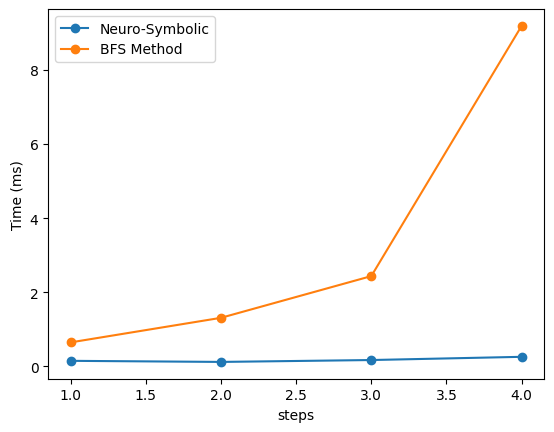

In [325]:
plt.plot([1, 2, 3, 4], [times0[0], times1[0], times2[0], times3[0]], marker='o')
plt.plot([1, 2, 3, 4], [times0[1], times1[1], times2[1], times3[1]], marker='o');
##~~~~ NN failed for steps = 4 ~~~~~~~~
# plt.scatter(4, times3[0], marker='x', color='red', s=100)
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.ylabel('Time (ms)')
plt.xlabel('steps')
plt.legend(['Neuro-Symbolic', 'BFS Method'])

In [326]:
def prove_with_nn(state, goal, model, ALL_FORMULAS, max_steps=10):
    state = list(state)

    for _ in range(max_steps):
        if goal in state:
            return True  

        # encode, rank predictions
        x = np.concatenate([encode_state(state, ALL_FORMULAS),encode_state([goal], ALL_FORMULAS)])
        tt = torch.tensor([x], dtype=torch.float32)
        logits = model(tt)[0]
        ranked = torch.argmax(logits).item()  # most likely next step

        f = ALL_FORMULAS[ranked]

        if f in state: return False

        state.append(f)

    return False  # max steps reached


In [327]:
def get_test_case(i):
    state = test_example(i)['state']
    goal = test_example(i)['goal']
    return state, goal

correct = 0
total = len(Xte)

for i in range(total):
    state, goal = get_test_case(i)
    if prove_with_nn(state, goal, model, ALL_FORMULAS):
        correct += 1

print("Global Proof Accuracy:", correct, "/", total, "=", correct/total)


Global Proof Accuracy: 6335 / 6389 = 0.9915479730787291


In [328]:
true_depths = []

for i in range(len(Xte)):
    state = test_example(i)['state']
    goal  = test_example(i)['goal']
    path  = find_shortest_proof(state, goal, ALL_FORMULAS, 5)
    true_depths.append(len(path))

print(sorted(set(true_depths)))


[1, 2, 3]


In [298]:
def accuracy_by_depth(Xte, true_depths, model, ALL_FORMULAS):
    results = {}
    depths = sorted(set(true_depths))

    for d in depths:
        idxs = [i for i,depth in enumerate(true_depths) if depth == d]
        if len(idxs) == 0:
            continue
            
    
        correct = 0
        for i in idxs:
            state, goal = test_example(i)['state'], test_example(i)['goal']
            if prove_with_nn(state, goal, model, ALL_FORMULAS):
                correct += 1

        results[d] = correct / len(idxs)

    return results

print(accuracy_by_depth(Xte, true_depths, model, ALL_FORMULAS))

{1: 1.0, 2: 0.9983238350653705, 3: 0.8956661316211878, 4: 0.725}
